# Epeak_Eiso_cosmology.ipynb
We have searched for a $E_\text{peak}- E_\text{iso}$ fit in the [Epeak-Eiso_correlation.ipynb](https://github.com/joanalnu/oab-inaf/blob/main/Epeak_Eiso_correlation.ipynb) and computed $E_\text{iso}$ from respective fluences $S$ in dependency of cosmology in [Eiso_from_fluence.ipynb](https://github.com/joanalnu/oab-inaf/blob7main/Eiso_from_fluence.ipynb). In this notebook, we employ all that to constrain the cosmological parameters, searching for $E_\text{peak}-E_\text{iso}$ fit with less scatter (i.e. shorter point-fit distances), indicating the 'best cosmology'.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from tqdm import tqdm
import itertools

from codecarbon import EmissionsTracker
tracker = EmissionsTracker()
import logging
logging.getLogger("codecarbon").setLevel(logging.ERROR)

[codecarbon INFO @ 10:29:18] Codecarbon is taking the configuration from global file: /Users/joanalnu/.codecarbon.config
[codecarbon WARNING @ 10:29:18] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 10:29:18] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 10:29:18] [setup] RAM Tracking...
[codecarbon INFO @ 10:29:18] [setup] CPU Tracking...
[codecarbon WARNING @ 10:29:18] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 10:29:18] CPU Model on constant consumption mode: Apple M1
[codecarbon WARNING @ 10:29:18] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:29:18] [setup] GPU Tracking...
[codecarbon INFO @ 10:29:18] No GPU found.
[codecarbon INFO @ 10:29:18] The below tracking methods have been set 

In [34]:
# read data
df = pd.read_csv('table.csv')

z = df['z']
Epeak = np.log10(df['Epeak'])
Epeak_err = df['Epeak_err']/(df['Epeak']*np.log(10))
original_Eiso = np.log10(df['Eiso'])
original_Eiso_err = df['Eiso_err']/(df['Eiso']*np.log(10))
Eiso_err = original_Eiso_err # cosmology invariant


# Convert H0 to cgs units: H0 [s^-1] = H0 [km/s/Mpc] * (km/Mpc to 1/s conversion)
# 1 Mpc = 3.086e24 cm, so H0_cgs = H0_kmsMpc * 1e5 / 3.086e24
H0_cgs = 70.0 * 1e5 / 3.086e24  # s^-1
Om_default = 0.3
Ode_default = 0.7
c = 2.99792458e10  # cm/s

# physics
# luminosity_distances, isotropic_equivalent_energy

def luminosity_distance(redshift, Ho=H0_cgs, O_m=Om_default, O_DE=Ode_default):
    """
    Calculate luminosity distance for given redshift(s) and cosmological parameters.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    Ho : float
        Hubble constant in cgs units (s^-1)
    O_m : float
        Matter density parameter
    O_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Luminosity distance in cm
    """

    def luminosity_distance_single(z, Ho=Ho, O_m=O_m, O_DE=O_DE):
        def integrand(z_prime):
            return 1.0 / np.sqrt(O_m * (1 + z_prime)**3 + O_DE)

        # Create redshift sample array
        z_array = np.linspace(0, z, num=1000)

        # Evaluate integrand on array
        y_values = integrand(z_array)

        # Compute definite integral from 0 to z
        integral = cumulative_trapezoid(y_values, z_array, initial=0)[-1]

        # Compute luminosity distance
        return (c * (1 + z) / Ho) * integral

    # Handle scalar and array inputs
    if np.isscalar(redshift):
        return luminosity_distance_single(redshift, Ho, O_m, O_DE)
    else:
        return np.array([luminosity_distance_single(z_i, Ho, O_m, O_DE) for z_i in redshift])

standard_dL = luminosity_distance(z,H0_cgs,Om_default,Ode_default) # to avoid computing the standard cosmology each time

def isotropic_equivalent_energy(redshift, Eiso=original_Eiso, H0=H0_cgs, Omega_m=Om_default, Omega_DE=Ode_default):
    """
    Calculate the isotropic equivalent energy.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    fluence : float or array
        Observed fluence (should be in erg/cm^2)
    H0 : float
        Hubble constant in cgs units (s^-1)
    Omega_m : float
        Matter density parameter
    Omega_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Log10 of isotropic equivalent energy
    """
    d_L = luminosity_distance(redshift, H0, Omega_m, Omega_DE)
    return (d_L/standard_dL) * Eiso

a future approach (at least for debugging) could be having only 1 free parameter (the y-axis cut), since this should be the only paramater changing with varying Eiso

In [35]:
# statistics
# linear_model, measure_distances, GoF, correlation

def linear_model(x, a, b):
    """
    Returns results array of a linear progression with slope a and by-axis cut b.
    :param x: array of x-axis values
    :param a: slope of the linear function
    :param b: y-axis cut of the linear function
    :return: results of a linear model to an array of x values
    """
    return a * x + b

def measure_distances(a, b, x, y):
    """
    Measures the distance between a point p = (x,y) and a line of best fit y=ax+b.
    :param a: slope of the fit
    :param b: y-axis cut of the fit
    :param x: x coordinate of the point
    :param y: y coordinate of the point
    :return: scalar for the distance
    """
    # for the line point we use x0=0 and thus y0=b
    numerator = abs(a*x - y + b)  # assuming linear model
    denominator = np.sqrt(1 + (a ** 2))
    return numerator / denominator

def reduced_chi_GoF(a, b, x, y, fit='linear model', xerr=None, yerr=None, extra_scatter=None):
    """
    Goodness of fit following the chi-squared formula
    :param a: slope
    :param b: y-axis cut
    :param x: x-values
    :param y: y-values
    :param fit: fitting function (defaults to linear_model)
    :param xerr: error bars (defaults to None)
    :param yerr: error bars (defaults to None)
    :param extra_scatter: extra scatter (already squared) (defaults to None)
    :return: chi-squared value using the equation
    """
    free = {
        'linear model': 2
    }
    model = np.zeros(len(x))
    if fit == 'linear model':
        model = linear_model(x, a, b)

    variance = 1.0
    if xerr is not None:
        variance -= xerr**2 * a
    if yerr is not None:
        variance += yerr**2
    if extra_scatter is not None:
        variance += extra_scatter

    chi_squared = ((y - model)**2) / (variance)
    reduced_chi_squared = np.sum(chi_squared)/(len(x)-free[fit])

    return reduced_chi_squared

def correlation(x, y=Epeak, xerr=Eiso_err, yerr=Epeak_err):
    """
    Find best fit parameters by minimizing chi-squared
    :param x: x-values
    :param y: y-values
    :param xerr: x error bars (defaults to None)
    :param yerr: y error bars (defaults to None)
    :return: best fit slope, intercept, and minimum chi-squared value
    """
    a = np.linspace(0.0, 1.0, 25)  # the slope must be positive
    b = np.linspace(-25., -20., 25)  # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20

    G = np.zeros([len(a), len(b)])  # G[i,j] corresponds to a[i], b[j]
    for alpha in range(len(a)):
        for beta in range(len(b)):
            G[alpha, beta] = reduced_chi_GoF(a[alpha], b[beta], x=x, y=y, xerr=xerr, yerr=yerr)

    # extract best fit parameters
    a_idx, b_idx = np.unravel_index(np.argmin(G), G.shape)
    return a[a_idx], b[b_idx], np.min(G)

In [4]:
# main

def main(Om,Ode):

    distances = np.zeros([len(Om), len(Ode), len(original_Eiso)])
    medians = np.zeros([len(Om), len(Ode)])
    chi_surface = np.zeros([len(Om), len(Ode)])

    # this 3D array consist of a Om-Ode 2 grid and the depth corresponding to the distance for each data point (75)
    for i, j in tqdm(itertools.product(range(len(Om)), range(len(Ode))), total=len(Om) * len(Ode), desc="Grid Search"):
    #for i in range(len(Om)):
        #for j in range(len(Ode)):
            #try:
                Eiso = isotropic_equivalent_energy(z,Omega_m=Om[i],Omega_DE=Ode[j])

                # check for NaN or inf values
                if np.any(~np.isfinite(Eiso)):
                    distances[i,j,:] = np.inf # instead of NaN which creates problems when finding minimum with argmin
                    medians[i,j] = np.inf
                    tqdm.write(f'{i} {j}\tOm={Om[i]}, Ode={Ode[j]}, Eiso contains infinity on NaN')
                    continue


                slope, intercept, chi_surface[i,j] = correlation(x=Eiso,y=Epeak,xerr=Eiso_err,yerr=Epeak_err)
                slope, intercept = np.polyfit(x=Eiso,y=Epeak,deg=1)
                distances[i,j,:] = measure_distances(slope, intercept, Eiso, Epeak)
                medians[i,j] = np.sum(distances[i,j,:])/len(distances[i,j,:])

                #print(f'{i} {j}\tOm={Om[i]:.3f}, Ode={Ode[j]:.3f}, m_fit={m_fit:.3f}, k_fit={k_fit:.3f}, median = {medians[i,j]:.3f}')
                fig, ax = plt.subplots(1,2, figsize=(8,5))
                ax[0].errorbar(Eiso, Epeak, xerr=Eiso_err, yerr=Epeak_err, fmt='o')
                ax[0].plot(Eiso, linear_model(Eiso, slope, intercept), c='r', label=f'fit: slope={slope:.3f}, intercept={intercept:.3f}')
                ax[0].set_xlabel(r'$E_\text{iso}$'); ax[0].set_ylabel(r'$E_\text{peak}$'); ax[0].legend()

                ax[1].hist(distances[i,j,:])
                ax[1].vlines(medians[i,j], 0, 14, colors='r', linestyles='dashed', label=f'median: {medians[i,j]:.3f}')
                ax[1].set_xlabel('data-fit distances'); ax[1].legend()

                plt.tight_layout()
                plt.title(fr'$\Omega_m=${Om[i]:.3f}, $\Omega_{{DE}}=${Ode[j]:.3f}')
                fig.savefig(f'figures/Om{Om[i]:.3f}_Ode{Ode[j]:.3f}_{i}{j}.png')
                plt.close()

            #except Exception as e:
            #    tqdm.write(f'Error at Om={Om[i]:.3f}, Ode={Ode[j]:.3f}')
            #    distances[i,j,:] = np.inf # mark as invalid

    np.save(f'distances/{distances.shape}_distances.npy', distances)

    return distances, medians, chi_surface

In [11]:
# Ploting
# create_mask, create_contourplot, add_constraint_lines


# now let's plot the (Om, Ode)mean surface
def create_mask(data, flat=True, no_big_bang=True):
    # Create a proper mask for unphysical regions
    # instead of a simple mask, the proper mask ensures that values aren't marked as NaN or 0, important for the argmin results
    mask = np.zeros_like(medians, dtype=bool)
    for i in range(len(Om)):
        for j in range(len(Ode)):
            if (Om[i]+Ode[j]>1.2 or # approx flat-universe region
                    Om[i]+Ode[j]<0.8):
                mask[i,j]=flat
            if (Ode[j]>Om[i]+1 or
                    Ode[j] >= Om[i]** (1/2.32) + 1.0 or # approx no big bang area
                    not np.isfinite(medians[i, j])):
                mask[i,j]=no_big_bang
            if data[i,j]==np.inf:
                mask[i,j]=True

    return np.ma.masked_where(mask,data)

def create_contourplot(p1, p2, surface, flat_mask=False, no_big_bang_mask=False, log=False, levels=100, datatype='chi'):
    def types(datatype):
        if datatype == 'chi': return r'$\chi^2$'
        elif datatype == 'distances': return 'Distances mean'
        else: return r'Distances mean or $\chi^2$'

    masked_surface = create_mask(surface, flat=flat_mask, no_big_bang=no_big_bang_mask)
    if log:
        masked_surface = np.log10(masked_surface)

    p1_idx, p2_idx = np.unravel_index(np.argmin(masked_surface), masked_surface.shape)
    p1_fit, p2_fit = p1[p1_idx], p2[p2_idx]

    print(f'Best fit: Om={p1_fit:.3f}, Ode={p2_fit:.3f}')
    print(f'Minimum average distance: {masked_surface[p1_idx,p2_idx]:.3}')

    plt.figure(figsize=(8, 6))
    im = plt.contourf(Om, Ode, masked_surface.T, cmap='jet', levels=levels)
    if log:
        plt.colorbar(im, label=f'Log {types(datatype)} surface')
    else:
        plt.colorbar(im, label=f'{types(datatype)} surface')
    plt.scatter(p1_fit, p2_fit, c='red', marker='x', s=100, linewidth=1, label=fr'Best fit: $\Omega_m$={p1_fit:.2f}, $\Omega_{{DE}}$={p2_fit:.2f}')
    plt.scatter(0.3, 0.7, c='black', marker='x', s=100, linewidths=1, label=r'Standard Cosmology $\Omega_m = 0.3,\ \Omega_{DE} = 0.7$')

    plt.xlabel(r'$\Omega_m$')
    plt.ylabel(r'$\Omega_{DE}$')
    plt.legend(loc='upper right')
    plt.xlim(Om[0],Om[-1]); plt.ylim(Ode[0],Ode[-1]); plt.tight_layout()

    return plt.gca()

def add_constraint_lines(plt):
    plt.plot(Om, 0.5*Om, linestyle='--', color='black', alpha=0.7)
    plt.annotate('accelerating', (1.5,0.80), rotation=26.35)
    plt.annotate('decelerating', (1.5,0.67), rotation=26.35)

    plt.plot(Om, Om**(1/2.32)+1, c='r', alpha=0.7)
    plt.annotate('NO BIG BANG', (0.05,1.55), rotation=45, color='red')

    plt.plot(Om, 1-Om, linestyle='--', color='gray', alpha=0.7)
    plt.annotate('open', (0.75,0.1), rotation=-45)
    plt.annotate('closed', (0.8,0.15), rotation=-45)

    return None

In [36]:
# Define cosmological parameter grids
Om = np.linspace(0.01,2.0,15)
Ode = np.linspace(0.01,2.0,15)

tracker.start()
distances, medians, chi_surface = main(Om, Ode)
tracker.stop()

Grid Search: 100%|██████████| 225/225 [00:45<00:00,  4.96it/s]


0.003913475480706476

Best fit: Om=0.863, Ode=2.000
Minimum average distance: 0.142


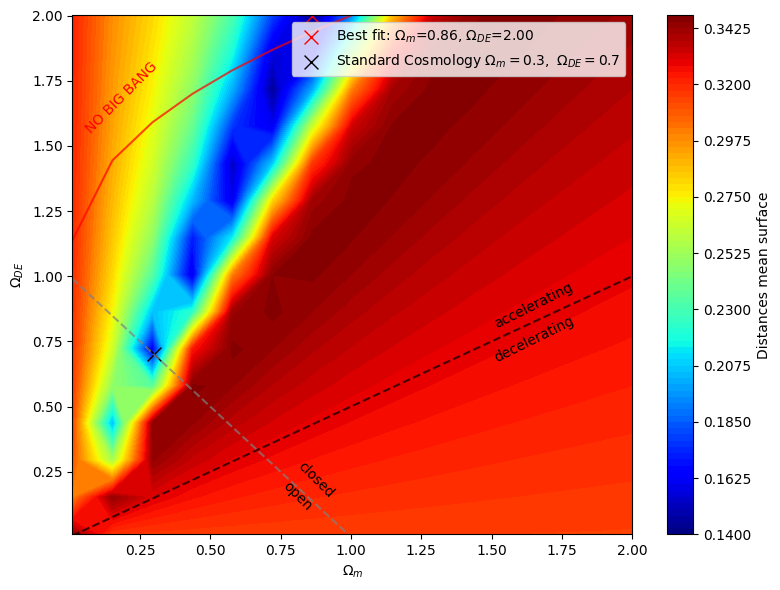

In [37]:
plot = create_contourplot(Om, Ode, medians, datatype='distances')
add_constraint_lines(plot)

Best fit: Om=0.436, Ode=1.005
Minimum average distance: 0.0461


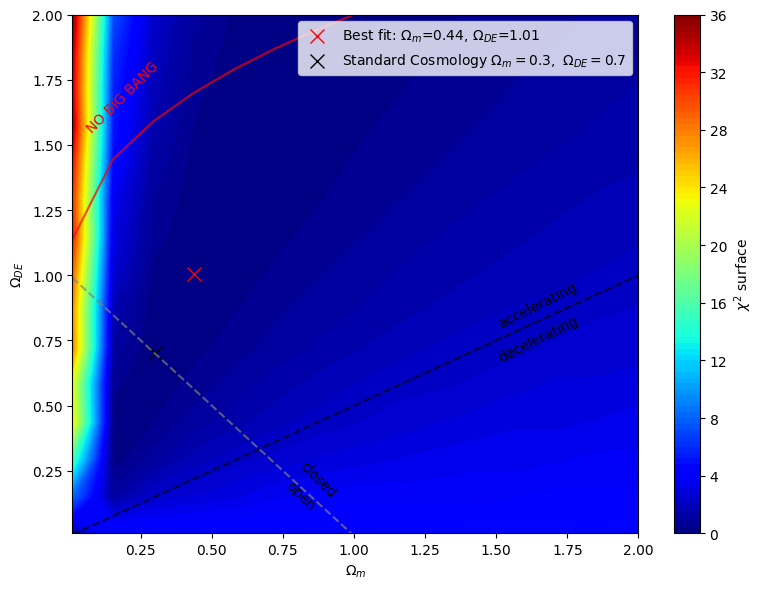

In [38]:
plot = create_contourplot(Om, Ode, chi_surface)
add_constraint_lines(plot)

### Basically the same, but with more resolution

Grid Search:   0%|          | 0/2500 [00:00<?, ?it/s]

0 0	Om=0.000, Ode=0.000, isotropic_model contains infinity or NaN
0 1	Om=0.000, Ode=0.041, isotropic_model contains infinity or NaN
0 2	Om=0.000, Ode=0.082, isotropic_model contains infinity or NaN
0 3	Om=0.000, Ode=0.122, isotropic_model contains infinity or NaN
0 4	Om=0.000, Ode=0.163, isotropic_model contains infinity or NaN
0 5	Om=0.000, Ode=0.204, isotropic_model contains infinity or NaN
0 6	Om=0.000, Ode=0.245, isotropic_model contains infinity or NaN
0 7	Om=0.000, Ode=0.286, isotropic_model contains infinity or NaN
0 8	Om=0.000, Ode=0.327, isotropic_model contains infinity or NaN
0 9	Om=0.000, Ode=0.367, isotropic_model contains infinity or NaN
0 10	Om=0.000, Ode=0.408, isotropic_model contains infinity or NaN
0 11	Om=0.000, Ode=0.449, isotropic_model contains infinity or NaN
0 12	Om=0.000, Ode=0.490, isotropic_model contains infinity or NaN
0 13	Om=0.000, Ode=0.531, isotropic_model contains infinity or NaN
0 14	Om=0.000, Ode=0.571, isotropic_model contains infinity or NaN
0 15	

/var/folders/lq/7_q5kjhn1pzgzvpl0fk8y5mc0000gp/T/ipykernel_56081/4232146145.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  return (c * (1 + z) / Ho) * integral
Grid Search:   3%|▎         | 87/2500 [00:00<00:05, 431.24it/s]

0 30	Om=0.000, Ode=1.224, isotropic_model contains infinity or NaN
0 31	Om=0.000, Ode=1.265, isotropic_model contains infinity or NaN
0 32	Om=0.000, Ode=1.306, isotropic_model contains infinity or NaN
0 33	Om=0.000, Ode=1.347, isotropic_model contains infinity or NaN
0 34	Om=0.000, Ode=1.388, isotropic_model contains infinity or NaN
0 35	Om=0.000, Ode=1.429, isotropic_model contains infinity or NaN
0 36	Om=0.000, Ode=1.469, isotropic_model contains infinity or NaN
0 37	Om=0.000, Ode=1.510, isotropic_model contains infinity or NaN
0 38	Om=0.000, Ode=1.551, isotropic_model contains infinity or NaN
0 39	Om=0.000, Ode=1.592, isotropic_model contains infinity or NaN
0 40	Om=0.000, Ode=1.633, isotropic_model contains infinity or NaN
0 41	Om=0.000, Ode=1.673, isotropic_model contains infinity or NaN
0 42	Om=0.000, Ode=1.714, isotropic_model contains infinity or NaN
0 43	Om=0.000, Ode=1.755, isotropic_model contains infinity or NaN
0 44	Om=0.000, Ode=1.796, isotropic_model contains infinity or

Grid Search:   7%|▋         | 175/2500 [00:00<00:05, 432.72it/s]

Error at Om=0.082, Ode=0.694: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.082, Ode=0.735: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.082, Ode=0.776: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.082, Ode=0.816: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.082, Ode=0.857: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.082, Ode=0.898: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.082, Ode=0.939: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.082, Ode=0.980: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.082, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.082, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.082, Ode=1.102: unsupporte

Grid Search:  11%|█         | 263/2500 [00:00<00:05, 433.06it/s]

Error at Om=0.163, Ode=0.245: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.163, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.163, Ode=0.327: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.163, Ode=0.367: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.163, Ode=0.408: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.163, Ode=0.449: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.163, Ode=0.490: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.163, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.163, Ode=0.571: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.163, Ode=0.612: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.163, Ode=0.653: unsupporte

Grid Search:  14%|█▍        | 351/2500 [00:00<00:04, 435.23it/s]

Error at Om=0.204, Ode=1.755: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.204, Ode=1.796: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.204, Ode=1.837: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.204, Ode=1.878: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.204, Ode=1.918: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.204, Ode=1.959: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.204, Ode=2.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.245, Ode=0.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.245, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.245, Ode=0.082: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.245, Ode=0.122: unsupporte

Grid Search:  18%|█▊        | 439/2500 [00:01<00:04, 435.69it/s]

Error at Om=0.286, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.286, Ode=1.347: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.286, Ode=1.388: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.286, Ode=1.429: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.286, Ode=1.469: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.286, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.286, Ode=1.551: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.286, Ode=1.592: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.286, Ode=1.633: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.286, Ode=1.673: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.286, Ode=1.714: unsupporte

Grid Search:  19%|█▉        | 483/2500 [00:01<00:04, 434.41it/s]

Error at Om=0.367, Ode=0.816: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.367, Ode=0.857: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.367, Ode=0.898: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.367, Ode=0.939: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.367, Ode=0.980: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.367, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.367, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.367, Ode=1.102: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.367, Ode=1.143: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.367, Ode=1.184: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.367, Ode=1.224: unsupporte

Grid Search:  21%|██        | 528/2500 [00:01<00:04, 436.32it/s]

Error at Om=0.408, Ode=1.143: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.408, Ode=1.184: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.408, Ode=1.224: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.408, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.408, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.408, Ode=1.347: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.408, Ode=1.388: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.408, Ode=1.429: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.408, Ode=1.469: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.408, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.408, Ode=1.551: unsupporte

Grid Search:  25%|██▍       | 616/2500 [00:01<00:04, 436.63it/s]

Error at Om=0.449, Ode=0.367: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.449, Ode=0.408: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.449, Ode=0.449: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.449, Ode=0.490: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.449, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.449, Ode=0.571: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.449, Ode=0.612: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.449, Ode=0.653: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.449, Ode=0.694: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.449, Ode=0.735: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.449, Ode=0.776: unsupporte

Grid Search:  28%|██▊       | 704/2500 [00:01<00:04, 436.30it/s]

Error at Om=0.490, Ode=1.959: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.490, Ode=2.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.531, Ode=0.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.531, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.531, Ode=0.082: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.531, Ode=0.122: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.531, Ode=0.163: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.531, Ode=0.204: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.531, Ode=0.245: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.531, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.531, Ode=0.327: unsupporte

Grid Search:  32%|███▏      | 793/2500 [00:01<00:03, 437.49it/s]

Error at Om=0.571, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.571, Ode=1.551: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.571, Ode=1.592: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.571, Ode=1.633: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.571, Ode=1.673: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.571, Ode=1.714: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.571, Ode=1.755: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.571, Ode=1.796: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.571, Ode=1.837: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.571, Ode=1.878: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.571, Ode=1.918: unsupporte

Grid Search:  33%|███▎      | 837/2500 [00:01<00:03, 434.82it/s]

Error at Om=0.653, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.653, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.653, Ode=1.102: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.653, Ode=1.143: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.653, Ode=1.184: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.653, Ode=1.224: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.653, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.653, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.653, Ode=1.347: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.653, Ode=1.388: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.653, Ode=1.429: unsupporte

Grid Search:  35%|███▌      | 881/2500 [00:02<00:03, 434.64it/s]

Error at Om=0.694, Ode=1.224: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.694, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.694, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.694, Ode=1.347: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.694, Ode=1.388: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.694, Ode=1.429: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.694, Ode=1.469: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.694, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.694, Ode=1.551: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.694, Ode=1.592: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.694, Ode=1.633: unsupporte

Grid Search:  37%|███▋      | 925/2500 [00:02<00:03, 433.29it/s]

Error at Om=0.735, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.735, Ode=0.571: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.735, Ode=0.612: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.735, Ode=0.653: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.735, Ode=0.694: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.735, Ode=0.735: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.735, Ode=0.776: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.735, Ode=0.816: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.735, Ode=0.857: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.735, Ode=0.898: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.735, Ode=0.939: unsupporte

Grid Search:  39%|███▉      | 970/2500 [00:02<00:03, 435.15it/s]

Error at Om=0.776, Ode=0.735: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.776, Ode=0.776: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.776, Ode=0.816: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.776, Ode=0.857: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.776, Ode=0.898: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.776, Ode=0.939: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.776, Ode=0.980: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.776, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.776, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.776, Ode=1.102: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.776, Ode=1.143: unsupporte

Grid Search:  41%|████      | 1014/2500 [00:02<00:03, 434.07it/s]

Error at Om=0.816, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.816, Ode=0.082: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.816, Ode=0.122: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.816, Ode=0.163: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.816, Ode=0.204: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.816, Ode=0.245: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.816, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.816, Ode=0.327: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.816, Ode=0.367: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.816, Ode=0.408: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.816, Ode=0.449: unsupporte

Grid Search:  42%|████▏     | 1058/2500 [00:02<00:03, 431.65it/s]

Error at Om=0.857, Ode=0.204: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=0.245: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=0.327: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=0.367: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=0.408: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=0.449: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=0.490: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=0.571: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=0.612: unsupporte

Grid Search:  44%|████▍     | 1102/2500 [00:02<00:03, 429.33it/s]

Error at Om=0.857, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=1.551: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=1.592: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=1.633: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=1.673: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=1.714: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=1.755: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=1.796: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=1.837: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=1.878: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.857, Ode=1.918: unsupporte

Grid Search:  46%|████▌     | 1146/2500 [00:02<00:03, 430.30it/s]

Error at Om=0.898, Ode=1.714: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.898, Ode=1.755: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.898, Ode=1.796: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.898, Ode=1.837: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.898, Ode=1.878: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.898, Ode=1.918: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.898, Ode=1.959: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.898, Ode=2.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=0.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=0.082: unsupporte

Grid Search:  48%|████▊     | 1190/2500 [00:02<00:03, 418.40it/s]

Error at Om=0.939, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=1.102: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=1.143: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=1.184: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=1.224: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=1.347: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=1.388: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.939, Ode=1.429: unsupporte

Grid Search:  49%|████▉     | 1234/2500 [00:02<00:02, 423.60it/s]

Error at Om=0.980, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.980, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.980, Ode=1.102: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.980, Ode=1.143: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.980, Ode=1.184: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.980, Ode=1.224: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.980, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.980, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.980, Ode=1.347: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.980, Ode=1.388: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=0.980, Ode=1.429: unsupporte

Grid Search:  51%|█████     | 1277/2500 [00:02<00:02, 424.86it/s]

Error at Om=1.020, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.020, Ode=0.327: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.020, Ode=0.367: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.020, Ode=0.408: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.020, Ode=0.449: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.020, Ode=0.490: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.020, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.020, Ode=0.571: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.020, Ode=0.612: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.020, Ode=0.653: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.020, Ode=0.694: unsupporte

Grid Search:  53%|█████▎    | 1320/2500 [00:03<00:02, 425.47it/s]

Error at Om=1.061, Ode=0.490: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=0.571: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=0.612: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=0.653: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=0.694: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=0.735: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=0.776: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=0.816: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=0.857: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=0.898: unsupporte

Grid Search:  55%|█████▍    | 1363/2500 [00:03<00:02, 426.33it/s]

Error at Om=1.061, Ode=1.796: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=1.837: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=1.878: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=1.918: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=1.959: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.061, Ode=2.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.102, Ode=0.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.102, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.102, Ode=0.082: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.102, Ode=0.122: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.102, Ode=0.163: unsupporte

Grid Search:  56%|█████▌    | 1406/2500 [00:03<00:02, 427.17it/s]

Error at Om=1.102, Ode=2.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=0.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=0.082: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=0.122: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=0.163: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=0.204: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=0.245: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=0.327: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=0.367: unsupporte

Grid Search:  58%|█████▊    | 1450/2500 [00:03<00:02, 428.83it/s]

Error at Om=1.143, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=1.347: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=1.388: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=1.429: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=1.469: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=1.551: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=1.592: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=1.633: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.143, Ode=1.673: unsupporte

Grid Search:  60%|█████▉    | 1493/2500 [00:03<00:02, 429.02it/s]

Error at Om=1.184, Ode=1.469: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.184, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.184, Ode=1.551: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.184, Ode=1.592: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.184, Ode=1.633: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.184, Ode=1.673: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.184, Ode=1.714: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.184, Ode=1.755: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.184, Ode=1.796: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.184, Ode=1.837: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.184, Ode=1.878: unsupporte

Grid Search:  61%|██████▏   | 1536/2500 [00:03<00:02, 426.65it/s]

Error at Om=1.224, Ode=0.735: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.224, Ode=0.776: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.224, Ode=0.816: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.224, Ode=0.857: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.224, Ode=0.898: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.224, Ode=0.939: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.224, Ode=0.980: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.224, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.224, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.224, Ode=1.102: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.224, Ode=1.143: unsupporte

Grid Search:  63%|██████▎   | 1580/2500 [00:03<00:02, 429.04it/s]

Error at Om=1.265, Ode=0.939: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.265, Ode=0.980: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.265, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.265, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.265, Ode=1.102: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.265, Ode=1.143: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.265, Ode=1.184: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.265, Ode=1.224: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.265, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.265, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.265, Ode=1.347: unsupporte

Grid Search:  65%|██████▍   | 1624/2500 [00:03<00:02, 430.89it/s]

Error at Om=1.306, Ode=0.204: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.306, Ode=0.245: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.306, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.306, Ode=0.327: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.306, Ode=0.367: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.306, Ode=0.408: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.306, Ode=0.449: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.306, Ode=0.490: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.306, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.306, Ode=0.571: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.306, Ode=0.612: unsupporte

Grid Search:  67%|██████▋   | 1668/2500 [00:03<00:01, 431.85it/s]

Error at Om=1.347, Ode=0.449: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=0.490: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=0.571: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=0.612: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=0.653: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=0.694: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=0.735: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=0.776: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=0.816: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=0.857: unsupporte

Grid Search:  68%|██████▊   | 1712/2500 [00:03<00:01, 431.39it/s]

Error at Om=1.347, Ode=1.755: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=1.796: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=1.837: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=1.878: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=1.918: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=1.959: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.347, Ode=2.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.388, Ode=0.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.388, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.388, Ode=0.082: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.388, Ode=0.122: unsupporte

Grid Search:  70%|███████   | 1756/2500 [00:04<00:01, 431.75it/s]

Error at Om=1.388, Ode=1.959: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.388, Ode=2.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=0.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=0.082: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=0.122: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=0.163: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=0.204: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=0.245: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=0.327: unsupporte

Grid Search:  72%|███████▏  | 1800/2500 [00:04<00:01, 430.36it/s]

Error at Om=1.429, Ode=1.224: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=1.347: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=1.388: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=1.429: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=1.469: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=1.551: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=1.592: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.429, Ode=1.633: unsupporte

Grid Search:  74%|███████▍  | 1844/2500 [00:04<00:01, 430.32it/s]

Error at Om=1.469, Ode=1.429: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.469, Ode=1.469: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.469, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.469, Ode=1.551: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.469, Ode=1.592: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.469, Ode=1.633: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.469, Ode=1.673: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.469, Ode=1.714: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.469, Ode=1.755: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.469, Ode=1.796: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.469, Ode=1.837: unsupporte

Grid Search:  76%|███████▌  | 1888/2500 [00:04<00:01, 430.49it/s]

Error at Om=1.510, Ode=0.694: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.510, Ode=0.735: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.510, Ode=0.776: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.510, Ode=0.816: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.510, Ode=0.857: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.510, Ode=0.898: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.510, Ode=0.939: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.510, Ode=0.980: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.510, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.510, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.510, Ode=1.102: unsupporte

Grid Search:  77%|███████▋  | 1932/2500 [00:04<00:01, 431.55it/s]

Error at Om=1.551, Ode=0.939: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.551, Ode=0.980: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.551, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.551, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.551, Ode=1.102: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.551, Ode=1.143: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.551, Ode=1.184: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.551, Ode=1.224: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.551, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.551, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.551, Ode=1.347: unsupporte

Grid Search:  79%|███████▉  | 1976/2500 [00:04<00:01, 430.04it/s]

Error at Om=1.592, Ode=0.163: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.592, Ode=0.204: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.592, Ode=0.245: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.592, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.592, Ode=0.327: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.592, Ode=0.367: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.592, Ode=0.408: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.592, Ode=0.449: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.592, Ode=0.490: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.592, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.592, Ode=0.571: unsupporte

Grid Search:  81%|████████  | 2020/2500 [00:04<00:01, 430.77it/s]

Error at Om=1.633, Ode=0.408: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=0.449: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=0.490: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=0.571: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=0.612: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=0.653: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=0.694: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=0.735: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=0.776: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=0.816: unsupporte

Grid Search:  83%|████████▎ | 2064/2500 [00:04<00:01, 431.64it/s]

Error at Om=1.633, Ode=1.714: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=1.755: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=1.796: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=1.837: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=1.878: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=1.918: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=1.959: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.633, Ode=2.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.673, Ode=0.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.673, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.673, Ode=0.082: unsupporte

Grid Search:  84%|████████▍ | 2108/2500 [00:04<00:00, 432.42it/s]

Error at Om=1.673, Ode=1.959: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.673, Ode=2.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=0.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=0.082: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=0.122: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=0.163: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=0.204: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=0.245: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=0.327: unsupporte

Grid Search:  86%|████████▌ | 2152/2500 [00:04<00:00, 432.28it/s]

Error at Om=1.714, Ode=1.184: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=1.224: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=1.347: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=1.388: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=1.429: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=1.469: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=1.551: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.714, Ode=1.592: unsupporte

Grid Search:  88%|████████▊ | 2196/2500 [00:05<00:00, 431.28it/s]

Error at Om=1.755, Ode=1.429: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.755, Ode=1.469: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.755, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.755, Ode=1.551: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.755, Ode=1.592: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.755, Ode=1.633: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.755, Ode=1.673: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.755, Ode=1.714: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.755, Ode=1.755: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.755, Ode=1.796: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.755, Ode=1.837: unsupporte

Grid Search:  90%|████████▉ | 2240/2500 [00:05<00:00, 431.01it/s]

Error at Om=1.796, Ode=0.694: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.796, Ode=0.735: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.796, Ode=0.776: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.796, Ode=0.816: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.796, Ode=0.857: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.796, Ode=0.898: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.796, Ode=0.939: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.796, Ode=0.980: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.796, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.796, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.796, Ode=1.102: unsupporte

Grid Search:  91%|█████████▏| 2284/2500 [00:05<00:00, 432.53it/s]

Error at Om=1.837, Ode=0.939: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.837, Ode=0.980: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.837, Ode=1.020: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.837, Ode=1.061: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.837, Ode=1.102: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.837, Ode=1.143: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.837, Ode=1.184: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.837, Ode=1.224: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.837, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.837, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.837, Ode=1.347: unsupporte

Grid Search:  93%|█████████▎| 2328/2500 [00:05<00:00, 432.93it/s]

Error at Om=1.878, Ode=0.204: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.878, Ode=0.245: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.878, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.878, Ode=0.327: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.878, Ode=0.367: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.878, Ode=0.408: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.878, Ode=0.449: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.878, Ode=0.490: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.878, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.878, Ode=0.571: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.878, Ode=0.612: unsupporte

Grid Search:  95%|█████████▍| 2372/2500 [00:05<00:00, 432.99it/s]

Error at Om=1.918, Ode=0.449: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=0.490: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=0.531: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=0.571: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=0.612: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=0.653: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=0.694: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=0.735: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=0.776: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=0.816: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=0.857: unsupporte

Grid Search:  97%|█████████▋| 2416/2500 [00:05<00:00, 431.51it/s]

Error at Om=1.918, Ode=1.755: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=1.796: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=1.837: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=1.878: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=1.918: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=1.959: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.918, Ode=2.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.959, Ode=0.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.959, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.959, Ode=0.082: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.959, Ode=0.122: unsupporte

Grid Search:  98%|█████████▊| 2460/2500 [00:05<00:00, 430.93it/s]

Error at Om=1.959, Ode=1.959: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=1.959, Ode=2.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=0.000: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=0.041: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=0.082: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=0.122: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=0.163: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=0.204: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=0.245: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=0.286: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=0.327: unsupporte

Grid Search: 100%|██████████| 2500/2500 [00:05<00:00, 431.44it/s]


Error at Om=2.000, Ode=1.224: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=1.265: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=1.306: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=1.347: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=1.388: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=1.429: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=1.469: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=1.510: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=1.551: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=1.592: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'
Error at Om=2.000, Ode=1.633: unsupporte

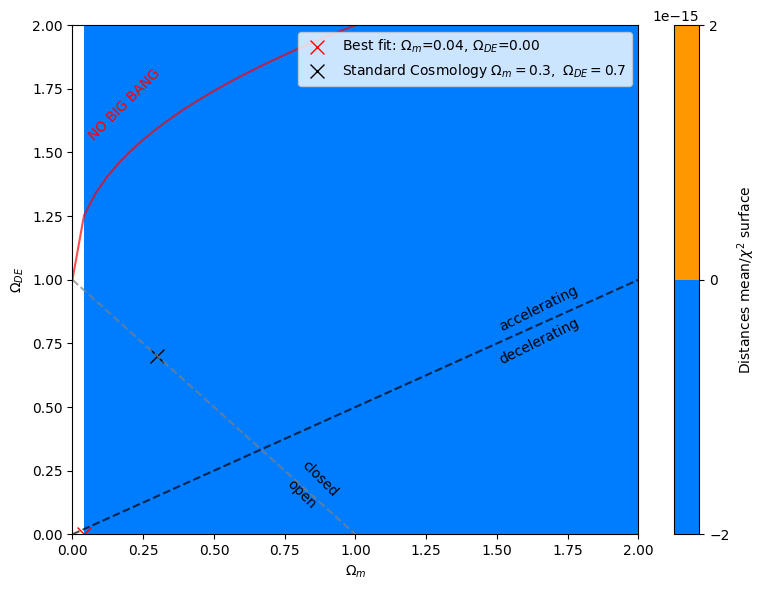

In [9]:
tracker.start()

# Define cosmological parameter grids
Om = np.linspace(0.0,2.0,50)
Ode = np.linspace(0.0,2.0,50)
k = np.linspace(-25.,-20.,25) # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20
m = np.linspace(0.0,1.0,25) # the slope must be positive

distances = np.zeros([len(Om), len(Ode), len(df['Eiso'])])
medians = np.zeros([len(Om), len(Ode)])

# this 3D array consist of a Om-Ode 2 grid and the depth corresponding to the distance for each data point (75)
for i, j in tqdm(itertools.product(range(len(Om)), range(len(Ode))), total=len(Om) * len(Ode), desc="Grid Search"):
#for i in range(len(Om)):
    #for j in range(len(Ode)):
        try:
            isotropic_model = isotropic_equivalent_energy(z,#S
                H0_cgs,Om[i],Ode[j])

            # check for NaN or inf values
            if np.any(~np.isfinite(isotropic_model)):
                distances[i,j,:] = np.inf # instead of NaN which creates problems when finding minimum with argmin
                medians[i,j] = np.inf
                print(f'{i} {j}\tOm={Om[i]:.3f}, Ode={Ode[j]:.3f}, isotropic_model contains infinity or NaN')
                continue

            G = np.zeros([len(m), len(k)]) # G[i,j] corresponds to m[i], k[j]
            for mu in range(len(m)):
                for nu in range(len(k)):
                    G[mu,nu] = GoF(m[mu], k[nu], x=isotropic_model, y=Epeak)

            # extract best fit parameters
            best_fit = np.argmin(G)
            m_index, k_index = np.unravel_index(best_fit, G.shape)
            m_fit, k_fit = m[m_index], k[k_index]
            distances[i,j,:] = measure_distances(m_fit, k_fit, isotropic_model, Epeak)

            #average = np.sum(distances[i,j,:])/len(distances[i,j,:])
            medians[i,j] = np.sum(distances[i,j,:])/len(distances[i,j,:])
            #(mu, sigma) = norm.fit(d[i,j,:]) # gaussian of best fit using scipy
            #x_data = np.linspace(np.min(d[i,j,:]), np.max(d[i,j,:]),100)
            #ax[i,j].plot(x_data, gaussian(x_data, mu, sigma), c='r')
            #ax[i,j].vlines(mu, 0, 20, colors='red', linestyles='--')

            #print(f'{i} {j}\tOm={Om[i]:.3f}, Ode={Ode[j]:.3f}, m_fit={m_fit:.3f}, k_fit={k_fit:.3f}, median = {medians[i,j]:.3f}')
            fig, ax = plt.subplots(1,2)
            ax[0].scatter(isotropic_model, Epeak, s=1)
            ax[0].plot(isotropic_model, m_fit*isotropic_model + k_fit, c='r', label=f'fit: m_fit={m_fit:.3f}, k_fit={k_fit:.3f}')
            ax[0].set_xlabel(r'$E_\text{iso}$'); ax[0].set_ylabel(r'$E_\text{peak}$'); ax[0].legend()

            ax[1].hist(distances[i,j,:])
            ax[1].vlines(medians[i,j], 0, 14, colors='r', linestyles='dashed', label=f'median: {medians[i,j]:.3f}')
            ax[1].set_xlabel('data-fit distances'); ax[1].legend()

            plt.tight_layout()
            fig.savefig(f'./highres-figures/Om{Om[i]:.3f}_Ode{Ode[j]:.3f}_{i}{j}.png')
            plt.close()

        except Exception as e:
            print(f'Error at Om={Om[i]:.3f}, Ode={Ode[j]:.3f}: {e}')
            distances[i,j,:] = np.inf # mark as invalid

np.save(f'{len(Om)}_{len(m)}_distances.npy', distances)

plot = create_contourplot(Om, Ode, medians)
add_constraint_lines(plot)